In [1]:
import os
import ccdproc
import numpy as np
import astropy.io.fits as pf
from astropy import units as u
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, datasets, DAOStarFinder

%matplotlib inline

In [2]:
def filelist(path):
    
    filename_list = [path + file for file in os.listdir(path)\
                     if file.endswith('.fits')]
    
    if filename_list:
        filename_list.sort()
        
    return filename_list

This function creates a list of file names using the variables `path`(the folder) and `file`(the file) providing the file has a `.fits` extension.

It then sorts the file names and returns the sorted list.

In [3]:
def filter_checker(filelist):
    r = []
    Ha = []
    
    for file in filelist:
        hdulist = pyfits.open(file)
    
        if (hdulist[0].header['INSFILTE'] == 'R'):
            r.append(file)
        
        elif (hdulist[0].header['INSFILTE'] == 'n40Ha'):
            Ha.append(file)
        
        else: # print warning for any addiotional filters used
            print('Additional filter found: '\
                  + str(hdulist[0].header['INSFILTE'])\
                 + ' - ' + str(hdulist[0].header['FILENAME']))
    
    return r, Ha

This function checks which filter was used on the apparatus to capture the light.

In [4]:
def trim(filename_list):
    
    trim = np.arange(0, 50, 1)

    for image in filename_list:
        img = pf.getdata(image,0)
        trimmed = np.delete(img, trim, 1)
        
        if trimmed.shape[0] == 2094:
            trimmed = np.delete(img, 2098-trim, 1)
    
    return trimmed

This function takes the list of image filenames, `filename_list`, loads each image using `pf.getdata` and trims the first 50 columns from the image.

It also checks if the image is 2 channel and deletes an extra 50 columns from the end.

It then returns the trimmed image.

In [5]:
def master_image(image_list):      
    
    imagecube = np.array(image_list)
    master_image = np.median(imagecube, axis=0)
    
    return master_image

This function receives the list of sourced and trimmed images, `image_list`. 

It creates the empty list `image_data`, cycles through `image_list` using the `for` loop and uses astropy's fits function, `pf.getdata`, to retreive the data from the raw image file. This is then appended to the `image_data` list.

This list is then flattened into `imagecube` and a master created by taking its median and assigning it to `master_image`.

`master_image` is then returned.

In [6]:
path = '../18mar14/bias/'

In [7]:
bias = filelist(path)

trimmed_bias = trim(bias)    
master_bias = master_image(trimmed_bias)
master_bias = ccdproc.CCDData(master_bias, unit=u.adu)

# plt.savefig('master_bias.png')

The cells above first set the `path` variable, then call the `bias` function using this path, then call the `trim` function on each image in the bias list, then call the `master_image` function on these trimmed images. The final line converts the `master_bias` to adu.

In [8]:
path_2 = '../18mar14/flat/'

In [9]:
flat = filelist(path_2)
r_flat, Ha_flat = filter_checker(flat)

if len(r_flat) != 0:
    trimmed_r_flat = trim(r_flat)    
    master_r_flat = master_image(trimmed_r_flat)
    master_r_flat = ccdproc.CCDData(master_r_flat, unit=u.adu)

elif len(Ha_flat) != 0:
    trimmed_Ha_flat = trim(Ha_flat)    
    master_Ha_flat = master_image(trimmed_Ha_flat)
    master_Ha_flat = ccdproc.CCDData(master_Ha_flat, unit=u.adu)
# plt.savefig('master_flat.png')

Additional filter found: U - F180314_0073.fits
Additional filter found: U - F180314_0074.fits
Additional filter found: U - F180314_0075.fits
Additional filter found: U - F180314_0076.fits
Additional filter found: U - F180314_0077.fits
Additional filter found: U - F180314_0078.fits
Additional filter found: U - F180314_0079.fits


This cell performs the same operations for the flat field images.

In [10]:
path_3 = '../18mar14/m61/'

In [11]:
target = filelist(path_3)
r_target, Ha_target = filter_checker(target)

$\text{R filter}$

In [12]:
trimmed_r_target = trim(r_target)
r_data = ccdproc.CCDData(trimmed_r_target, unit=u.adu)

r_bias_subtracted = ccdproc.subtract_bias(r_data, master_bias)
r_reduced_image = ccdproc.flat_correct(r_bias_subtracted, master_r_flat)
    
r_mean, r_median, r_std = sigma_clipped_stats(r_reduced_image, sigma=10.0, iters=5)

NameError: name 'master_r_flat' is not defined

$\text{H}_{\alpha}\text{ filter}$

In [ ]:
trimmed_Ha_target = trim(Ha_target)
Ha_data = ccdproc.CCDData(trimmed_Ha_target, unit=u.adu)

Ha_bias_subtracted = ccdproc.subtract_bias(Ha_data, master_bias)#Ha_bias)
Ha_reduced_image = ccdproc.flat_correct(Ha_bias_subtracted, master_Ha_flat)
    
Ha_mean, Ha_median, Ha_std = sigma_clipped_stats(Ha_reduced_image, sigma=10.0, iters=5)

The above cells first  set a new `path`. They then generate a list of image filenames, trim each image in the list and convert them to adu in a similar manner to the bias cells above.

The `master_bias` frame generated earlier is then subtracted and re-assigned to `image`. 

The `sigma_clipped_stats` function is then used to generated the mean, median and standard deviation of the image.

The `DAOStarFinder` function is then initialised and used to detect stars in the median subtracted image. This result is the final required source.

/home/damien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/damien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


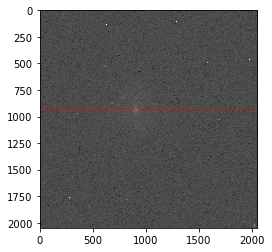

In [63]:
# plt.subplot(211)
# plt.imshow(np.log10(r_reduced_image))#, cmap='Greys')

# plt.subplot(212)
plt.imshow(np.log10(Ha_reduced_image), cmap='gist_gray')
plt.axhline(y=926, color='r', linestyle='--', alpha=0.5)

# plt.savefig('reduced.png')

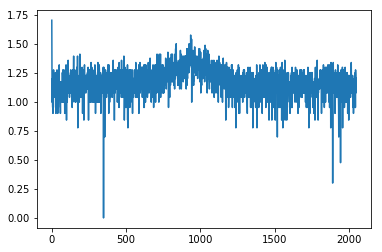

In [60]:
plt.plot(range(2048), np.log10(np.array(Ha_reduced_image[:,926])))

$\large{\text{Smoothing}}$

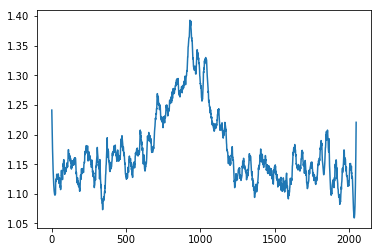

In [61]:
from scipy.signal import savgol_filter
yhat = savgol_filter(np.log10(np.array(Ha_reduced_image[:,926])), 51, 3)

plt.plot(range(2048), yhat)

This final cell first generates the positions tuple using `sources`. The apertures required for the sources is then set. 

The image is then normalised and displayed with a logarithmic scale.

Finally the `sources` are plotted over the top of the background using the `apertures.plot` function.

In [14]:
hdu_r_bias = pf.PrimaryHDU(r_master_bias)
hdu_r_bias.writeto('r_bias.fits', overwrite=True)

hdu_Ha_bias = pf.PrimaryHDU(Ha_master_bias)
hdu_Ha_bias.writeto('Ha_bias.fits', overwrite=True)

In [15]:
hdu_r_flat = pf.PrimaryHDU(r_master_flat)
hdu_r_flat.writeto('r_flat.fits', overwrite=True)

hdu_Ha_flat = pf.PrimaryHDU(Ha_master_flat)
hdu_Ha_flat.writeto('Ha_flat.fits', overwrite=True)

In [64]:
# hdu_r = pf.PrimaryHDU(r_reduced_image)
# hdu_r.writeto('r_reduced.fits', overwrite=True)

hdu_Ha = pf.PrimaryHDU(Ha_reduced_image)
hdu_Ha.writeto('Ha_reduced.fits', overwrite=True)

$\large{\textbf{Adjusting Sigma}}$

In [17]:
mean_2, median_2, std_2 = sigma_clipped_stats(reduced_image, sigma=3.0, iters=5)
# daofind_2 = DAOStarFinder(fwhm=3.0, threshold=10*std_2)
# sources_2 = daofind_2(reduced_image-median_2)

/home/damien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/damien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


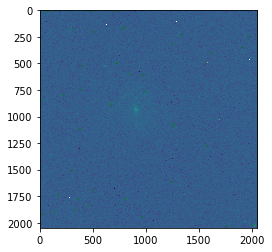

In [19]:
# positions_2 = (sources_2['xcentroid'], sources_2['ycentroid'])
# apertures_2 = CircularAperture(positions_2, r=4.0)

# norm_2 = ImageNormalize(stretch=SqrtStretch())
plt.imshow(np.log10(reduced_image))#, cmap='Greys')

# apertures_2.plot(color='green', lw=1.5, alpha=0.5)

$\Large{\textbf{Extra functionality}}$

Any flats and darks which may be present in the data set can be processed in a similar manner to the bias files above.

In [ ]:
# insert this line after "bias_subtracted = ccdproc...."
reduced_image = ccdproc.flat_correct(bias_subtracted, master_flat) # inserted already

In [ ]:
xshift = [ 0, -2, -3, -5, -3, 10, 17, 17,  3,  5, -2, -2, 8]
yshift = [0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0]

xrolled = np.roll(reduced_image, int(-xshift[index]), axis=1)
rolled = np.roll(xrolled, int(-yshift[index]), axis=0)

The `np.roll` command shifts an array along a specified axis by a specified amount, ie. `array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7])` is an array rolled by 2.